In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm

from models import LeNet_BNN, LeNet_BNN_uni, LeNet
from utils import train_BNN, train_DNN, test_BNN, test_DNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dnn = LeNet()
dnn.load_state_dict(torch.load('runs/dnn_bs1024_lr0.001_mc100_temp_1.0_ep100_20240711-160323/best_model.pth'))

# MNIST dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True)

test_DNN(dnn, test_loader)


In [ ]:
# bnn_uni = LeNet_BNN_uni().to(device)
# bnn_uni.load_state_dict(torch.load('bnn_uni.pth'))
# # train_BNN(10, bnn_uni)
# test_BNN(bnn_uni, test_loader, 100, 1024, 'cuda')

### $\mu$, $\sigma$ 학습 가능한지 확인

In [ ]:
from torch.distributions import Normal
target_w = 3.0

# Sample the weights
mu = torch.nn.Parameter(torch.Tensor(1))
sigma = torch.nn.Parameter(torch.Tensor(1))
mu.data.normal_(0, 0.1)
sigma.data.normal_(1, 0.1)

w_dist = Normal(mu,sigma)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam([mu, sigma], lr=0.01)

# Log for plotting
mu_log = []
sigma_log = []

# Sample the weights
for epoch in range(1000):
    w = w_dist.rsample()
    
    loss_val = loss(w, torch.Tensor([target_w]))
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    mu_log.append(mu.item())
    sigma_log.append(sigma.item())
    
import matplotlib.pyplot as plt

plt.plot(mu_log)
plt.plot(sigma_log)
plt.grid()
plt.legend(['mu', 'sigma'])

# plot target
plt.plot([0,1000], [target_w, target_w], 'r--')

### 신경망 모델의 가중치를 분포로 학습가능한지 확인 $w_i \sim \mathbf{N}(\mu_i,\sigma_i)$

In [ ]:

w_conv1_dnn = dnn.conv1.weight.data

# Sample the weights
mu = torch.nn.Parameter(torch.zeros_like(w_conv1_dnn))
sigma = torch.nn.Parameter(torch.ones_like(w_conv1_dnn))

w_dist = Normal(mu,sigma)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam([mu, sigma], lr=0.01)

# Log for plotting
mu_log = []
sigma_log = []
losses = []
for epoch in tqdm(range(1000)):
    w = w_dist.rsample()
    
    loss_val = loss(w, w_conv1_dnn)
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    mu_log.append(mu.mean().item())
    sigma_log.append(sigma.mean().item())
    losses.append(loss_val.item())
    
# plot training progress
plt.plot(losses)
plt.plot(mu_log)
plt.plot(sigma_log)
plt.grid()
plt.legend(['loss', 'mu', 'sigma'])

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 예시 데이터, 실제 데이터로 대체하세요.
mu_kernel = mu  # 실제 mu_kernel 값으로 대체
rho_kernel = sigma  # 실제 rho_kernel 값으로 대체
w_dnn = dnn.conv1.weight.data
# sigma_weight 계산
sigma_weight = torch.log1p(torch.exp(rho_kernel))

plt.figure(figsize=(15,15))
for idx, (w_target, mu, sigma) in enumerate(zip(w_dnn, mu_kernel, sigma_weight)):
    
    print(w_target.shape, mu.shape, sigma.shape)
    w_target = w_target.cpu().detach().numpy()
    plt.subplot(6,1, idx+1)
    for i in range(3):
        
        for j in range(3):
            
            plt.axvline(x=w_target[0,i,j], color='r', linestyle='--', label='target')
            
            x = np.linspace(mu[0,i,j].item() - 3 * sigma[0,i,j].item(), mu[0,i,j].item() + 3 * sigma[0,i,j].item(), 1000)
            pdf = norm.pdf(x, loc=mu[0,i,j].item(), scale= sigma[0,i,j].item())
            # plt.subplot(3,3,i+j+1)

            plt.plot(x, pdf, label=f'N({mu[0,i,j].item():.2f}, {sigma[0,i,j].item():.2f})')
            
        

### 만약 입력 X까지 고려한 출력 y를 loss로 사용한다면?

In [ ]:
# bnn_uni = LeNet_BNN_uni().to(device)
# loss = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(bnn_uni.conv1.parameters(), lr=0.01)

# losses = []

# for e in range(10):
#     for x,y in tqdm(train_loader):
        
#         y_bnn, _ = bnn_uni.conv1.forward(x.to(device))
        
            
#         y_dnn = dnn.conv1.forward(x.to(device))

#         loss_val = loss(y_bnn, y_dnn)

#         optimizer.zero_grad()
#         loss_val.backward()
#         optimizer.step()
        
#         losses.append(loss_val.item())
    


# plt.plot(losses)
# plt.grid()

# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm

# # 예시 데이터, 실제 데이터로 대체하세요.
# mu_kernel = bnn_uni.conv1.mu_kernel  # 실제 mu_kernel 값으로 대체
# rho_kernel = bnn_uni.conv1.rho_kernel  # 실제 rho_kernel 값으로 대체
# w_dnn = dnn.conv1.weight.data
# # sigma_weight 계산
# sigma_weight = torch.log1p(torch.exp(rho_kernel))

# plt.figure(figsize=(15,15))
# for idx, (w_target, mu, sigma) in enumerate(zip(w_dnn, mu_kernel, sigma_weight)):
    
#     print(w_target.shape, mu.shape, sigma.shape)
#     w_target = w_target.cpu().detach().numpy()
#     plt.subplot(6,1, idx+1)
#     for i in range(3):
        
#         for j in range(3):
            
#             plt.axvline(x=w_target[0,i,j], color='r', linestyle='--', label='target')
            
#             x = np.linspace(mu[0,i,j].item() - 3 * sigma[0,i,j].item(), mu[0,i,j].item() + 3 * sigma[0,i,j].item(), 1000)
#             pdf = norm.pdf(x, loc=mu[0,i,j].item(), scale= sigma[0,i,j].item())
#             # plt.subplot(3,3,i+j+1)

#             plt.plot(x, pdf, label=f'N({mu[0,i,j].item():.2f}, {sigma[0,i,j].item():.2f})')
            
        

### Aleatoric?

In [ ]:
bnn_uni = LeNet_BNN_uni().to(device)

In [ ]:

w_conv1_dnn = dnn.conv1.weight.data

# Sample the weights

# loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam([bnn_uni.conv1.mu_kernel, bnn_uni.conv1.rho_kernel], lr=1e-3)

# Log for plotting
mu_log = []
sigma_log = []
losses = []
for epoch in range(1000):
    
    mu = bnn_uni.conv1.mu_kernel
    sigma = torch.log1p(torch.exp(bnn_uni.conv1.rho_kernel))

    loss_val = 0.5 * torch.mean((mu - w_conv1_dnn)**2 / sigma + sigma )
        
        
    
    # loss_val = loss(w, w_conv1_dnn)
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    mu_log.append(mu.mean().item())
    sigma_log.append(sigma.mean().item())
    losses.append(loss_val.item())
    
# plot training progress
plt.plot(losses)
plt.plot(mu_log)
plt.plot(sigma_log)
plt.grid()
plt.legend(['loss', 'mu', 'sigma'])

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 예시 데이터, 실제 데이터로 대체하세요.
mu_kernel = bnn_uni.conv1.mu_kernel  # 실제 mu_kernel 값으로 대체
rho_kernel = bnn_uni.conv1.rho_kernel  # 실제 rho_kernel 값으로 대체
w_dnn = dnn.conv1.weight.data
# sigma_weight 계산
sigma_weight = torch.log1p(torch.exp(rho_kernel))

plt.figure(figsize=(15,15))
for idx, (w_target, mu, sigma) in enumerate(zip(w_dnn, mu_kernel, sigma_weight)):
    
    print(w_target.shape, mu.shape, sigma.shape)
    w_target = w_target.cpu().detach().numpy()
    plt.subplot(6,1, idx+1)
    for i in range(3):
        
        for j in range(3):
            
            plt.axvline(x=w_target[0,i,j], color='r', linestyle='--', label='target')
            
            x = np.linspace(mu[0,i,j].item() - 3 * sigma[0,i,j].item(), mu[0,i,j].item() + 3 * sigma[0,i,j].item(), 1000)
            pdf = norm.pdf(x, loc=mu[0,i,j].item(), scale= sigma[0,i,j].item())
            # plt.subplot(3,3,i+j+1)

            plt.plot(x, pdf, label=f'N({mu[0,i,j].item():.2f}, {sigma[0,i,j].item():.2f})')
            
        

In [ ]:

w_conv2_dnn = dnn.conv2.weight.data

# Sample the weights

# loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam([bnn_uni.conv2.mu_kernel, bnn_uni.conv2.rho_kernel], lr=1e-3)

# Log for plotting
mu_log = []
sigma_log = []
losses = []
for epoch in range(1000):
    
    mu = bnn_uni.conv2.mu_kernel
    sigma = torch.log1p(torch.exp(bnn_uni.conv2.rho_kernel))

    loss_val = 0.5 * torch.mean((mu - w_conv2_dnn)**2 / sigma + sigma )
        
        
    
    # loss_val = loss(w, w_conv2_dnn)
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    mu_log.append(mu.mean().item())
    sigma_log.append(sigma.mean().item())
    losses.append(loss_val.item())
    
# plot training progress
plt.plot(losses)
plt.plot(mu_log)
plt.plot(sigma_log)
plt.grid()
plt.legend(['loss', 'mu', 'sigma'])

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 예시 데이터, 실제 데이터로 대체하세요.
mu_kernel = bnn_uni.conv2.mu_kernel  # 실제 mu_kernel 값으로 대체
print(mu_kernel.shape)
rho_kernel = bnn_uni.conv2.rho_kernel  # 실제 rho_kernel 값으로 대체
w_dnn = dnn.conv2.weight.data
# sigma_weight 계산
sigma_weight = torch.log1p(torch.exp(rho_kernel))

plt.figure(figsize=(15,15))
for idx, (w_target, mu, sigma) in enumerate(zip(w_dnn, mu_kernel, sigma_weight)):
    
    print(w_target.shape, mu.shape, sigma.shape)
    w_target = w_target.cpu().detach().numpy()
    plt.subplot(16,1, idx+1)
    for i in range(3):
        
        for j in range(3):
            
            plt.axvline(x=w_target[0,i,j], color='r', linestyle='--', label='target')
            
            x = np.linspace(mu[0,i,j].item() - 3 * sigma[0,i,j].item(), mu[0,i,j].item() + 3 * sigma[0,i,j].item(), 1000)
            pdf = norm.pdf(x, loc=mu[0,i,j].item(), scale= sigma[0,i,j].item())
            # plt.subplot(3,3,i+j+1)

            plt.plot(x, pdf, label=f'N({mu[0,i,j].item():.2f}, {sigma[0,i,j].item():.2f})')
            
        

### Set the Prior distribution 

In [ ]:
bnn_new = LeNet_BNN_uni().to(device)

In [ ]:
bnn_new.conv1.prior_mean, bnn_new.conv1.prior_variance, bnn_new.conv2.prior_mean, bnn_new.conv2.prior_variance

In [ ]:
# bnn_new.conv1.prior_mean = bnn_uni.conv1.mu_kernel.detach().clone()
# bnn_new.conv1.prior_variance = torch.log1p(torch.exp(bnn_uni.conv1.rho_kernel)).detach().clone()

# bnn_new.conv2.prior_mean = bnn_uni.conv2.mu_kernel.detach().clone()
# bnn_new.conv2.prior_variance = torch.log1p(torch.exp(bnn_uni.conv2.rho_kernel)).detach().clone()

In [ ]:
bnn_new.conv1.prior_weight_mu = bnn_uni.conv1.mu_kernel.detach().clone()
bnn_new.conv1.prior_weight_sigma = torch.log1p(torch.exp(bnn_uni.conv1.rho_kernel)).detach().clone()

bnn_new.conv2.prior_weight_mu = bnn_uni.conv2.mu_kernel.detach().clone()
bnn_new.conv2.prior_weight_sigma = torch.log1p(torch.exp(bnn_uni.conv2.rho_kernel)).detach().clone()

In [ ]:
# import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter
# class args:
#     pass
# args = args()
# args.t = 1.0
# writer = SummaryWriter(f'runs/bnn_new2')
# train_BNN(epoch= 100, model = bnn_new, train_loader= train_loader, test_loader= test_loader, optimizer= optim.Adam(bnn_new.parameters(), lr=1e-3), writer = writer, mc_runs = 100, bs = 1024, device = 'cuda', args=args)

### MOPED

In [ ]:
# from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
# from torch.utils.tensorboard import SummaryWriter
# bnn_rho_init = -3.0
# moped_delta_factor = 0.2
# const_bnn_prior_parameters = {
#         "prior_mu": 0.0,
#         "prior_sigma": 1.0,
#         "posterior_mu_init": 0.0,
#         "posterior_rho_init": bnn_rho_init,
#         "type": "Reparameterization",  # Flipout or Reparameterization
#         "moped_enable": True,  # initialize mu/sigma from the dnn weights
#         "moped_delta": moped_delta_factor,
#     }


# dnn_moped = LeNet()
# dnn_moped.load_state_dict(torch.load('runs/dnn_bs1024_lr0.001_mc100_temp_1.0_ep100_20240711-160323/best_model.pth'))

# dnn_to_bnn(dnn_moped, const_bnn_prior_parameters)

# class args:
#     pass

# args = args()
# args.t = 1.0
# writer = SummaryWriter(f'runs/dnn_moped2')
# train_BNN(epoch= 100, model = dnn_moped.cuda(), train_loader= train_loader, test_loader= test_loader, optimizer= optim.Adam(dnn_moped.parameters(), lr=1e-3), writer = writer, mc_runs = 100, bs = 1024, device = 'cuda', args=args, moped=True)



### multivariate Gaussian distribution

### covariance matrix 학습 가능한지 확인

In [ ]:
target_matrix = torch.eye(10, requires_grad=True)

L_init = torch.tril(torch.rand(10,10))
L = nn.Parameter(L_init)

optimizer = optim.Adam([L], lr=1e-2)

losses = []
for epoch in range(1000):
    
    loss = 0.5 * torch.sum((L.T @ L - target_matrix)**2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
plt.plot(losses)
plt.grid()


In [ ]:
plt.imshow((L.T@L).detach().numpy())

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)

import copy
cov_not_optimized = bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()  
print(cov_not_optimized.shape)
optimizer = optim.Adam([bnn_multi.conv1.mu_kernel, bnn_multi.conv1.L_param], lr=1e-2)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    c_in, c_out, k, _ = w_conv1_dnn.size()
    
    mu = bnn_multi.conv1.mu_kernel
    mu_flat = mu.view(-1)
    w_flat = w_conv1_dnn.view(-1)

    epslion = 1e-6
    cov = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in * c_out * k * k).to(device)
    
    # Sampling the weight
    w = torch.distributions.MultivariateNormal(mu_flat, cov).rsample().reshape(c_in, c_out, k, k)
    
    # k_value = torch.tensor(k, dtype=torch.float32).to(device)
    # pi_value = torch.tensor(torch.pi, dtype=torch.float32).to(device)
    # nnl = 0.5 * (k_value * torch.log(2 * pi_value) + torch.logdet(cov) + (w_flat - mu_flat).t() @ torch.inverse(cov) @ (w_flat - mu_flat))

    nnl = (w - w_conv1_dnn).pow(2).mean()
    optimizer.zero_grad()
    nnl.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu.mean().item())
    
    losses.append(nnl.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(cov_not_optimized[:9,:9])
plt.title('Covariance matrix (not optimized)')

plt.subplot(1,3,2)
i=1
plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
plt.title('Covariance matrix (optimized)')
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


In [ ]:
bnn_multi.conv1.L_param.T.shape

In [ ]:
import torch
import matplotlib.pyplot as plt

# Sample the weights
weight_dist = torch.distributions.MultivariateNormal(
    bnn_multi.conv1.mu_kernel.view(-1),
    bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in * c_out * k * k).to(device)
)

w_bnn = weight_dist.rsample().reshape(6, 1, 3, 3).view(-1)
w_dnn = dnn.conv1.weight.data.view(-1)

# Visualize the difference using vertical lines
plt.figure(figsize=(10, 5))
x = range(len(w_dnn.cpu().detach().numpy()))

# # Plot DNN weights with thicker lines
# plt.vlines(x, ymin=0, ymax=w_dnn.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# # Plot BNN weights with thinner lines
# plt.vlines(x, ymin=0, ymax=w_bnn.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

# Plot differences

plt.vlines(x, ymin=0, ymax=(w_dnn.cpu().detach() - w_bnn.cpu().detach()).abs(), color='g', linewidth=1, label='DNN - BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Learned)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (abs)')
plt.ylim(0,3)
plt.show()


## Cov randomly initialized

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)

import copy
cov_not_optimized = bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()  
print(cov_not_optimized.shape)
optimizer = optim.Adam([bnn_multi.conv1.mu_kernel], lr=1e-2)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    c_in, c_out, k, _ = w_conv1_dnn.size()
    
    mu = bnn_multi.conv1.mu_kernel
    mu_flat = mu.view(-1)
    w_flat = w_conv1_dnn.view(-1)

    epslion = 1e-6
    cov = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in * c_out * k * k).to(device)
    
    # Sampling the weight
    w = torch.distributions.MultivariateNormal(mu_flat, cov).rsample().reshape(c_in, c_out, k, k)
    
    # k_value = torch.tensor(k, dtype=torch.float32).to(device)
    # pi_value = torch.tensor(torch.pi, dtype=torch.float32).to(device)
    # nnl = 0.5 * (k_value * torch.log(2 * pi_value) + torch.logdet(cov) + (w_flat - mu_flat).t() @ torch.inverse(cov) @ (w_flat - mu_flat))

    nnl = (w - w_conv1_dnn).pow(2).mean()
    optimizer.zero_grad()
    nnl.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu.mean().item())
    
    losses.append(nnl.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(cov_not_optimized[:9,:9])
plt.title('Covariance matrix (not optimized)')

plt.subplot(1,3,2)
i=1
plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
plt.title('Covariance matrix (optimized)')
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


In [ ]:
import torch
import matplotlib.pyplot as plt

# Sample the weights
weight_dist = torch.distributions.MultivariateNormal(
    bnn_multi.conv1.mu_kernel.view(-1),
    bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in * c_out * k * k).to(device)
)

w_bnn = weight_dist.rsample().reshape(6, 1, 3, 3).view(-1)
w_dnn = dnn.conv1.weight.data.view(-1)

# Visualize the difference using vertical lines
plt.figure(figsize=(10, 5))
x = range(len(w_dnn.cpu().detach().numpy()))

# # Plot DNN weights with thicker lines
# plt.vlines(x, ymin=0, ymax=w_dnn.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# # Plot BNN weights with thinner lines
# plt.vlines(x, ymin=0, ymax=w_bnn.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

# Plot differences

plt.vlines(x, ymin=0, ymax=(w_dnn.cpu().detach() - w_bnn.cpu().detach()).abs(), color='r', linewidth=1, label='DNN - BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Randomly Initialized)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (abs)')
plt.ylim(0,3)
plt.show()


# cov = I

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)

import copy
cov_not_optimized = bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()  
print(cov_not_optimized.shape)
optimizer = optim.Adam([bnn_multi.conv1.mu_kernel, bnn_multi.conv1.L_param], lr=1e-2)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    c_in, c_out, k, _ = w_conv1_dnn.size()
    
    mu = bnn_multi.conv1.mu_kernel
    mu_flat = mu.view(-1)
    w_flat = w_conv1_dnn.view(-1)

    epslion = 1e-6
    cov = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in * c_out * k * k).to(device)
    
    # Sampling the weight
    w = torch.distributions.MultivariateNormal(mu_flat, torch.eye(c_in * c_out * k * k).to(device)).rsample().reshape(c_in, c_out, k, k)
    
    # k_value = torch.tensor(k, dtype=torch.float32).to(device)
    # pi_value = torch.tensor(torch.pi, dtype=torch.float32).to(device)
    # nnl = 0.5 * (k_value * torch.log(2 * pi_value) + torch.logdet(cov) + (w_flat - mu_flat).t() @ torch.inverse(cov) @ (w_flat - mu_flat))

    nnl = (w - w_conv1_dnn).pow(2).mean()
    optimizer.zero_grad()
    nnl.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu.mean().item())
    
    losses.append(nnl.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(cov_not_optimized[:9,:9])
plt.title('Covariance matrix (not optimized)')

plt.subplot(1,3,2)
i=1
plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
plt.title('Covariance matrix (optimized)')
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


In [ ]:
import torch
import matplotlib.pyplot as plt

# Sample the weights
weight_dist = torch.distributions.MultivariateNormal(
    bnn_multi.conv1.mu_kernel.view(-1),
    torch.eye(c_in * c_out * k * k).to(device)
)

w_bnn = weight_dist.rsample().reshape(6, 1, 3, 3).view(-1)
w_dnn = dnn.conv1.weight.data.view(-1)

# Visualize the difference using vertical lines
plt.figure(figsize=(10, 5))
x = range(len(w_dnn.cpu().detach().numpy()))

# # Plot DNN weights with thicker lines
# plt.vlines(x, ymin=0, ymax=w_dnn.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# # Plot BNN weights with thinner lines
# plt.vlines(x, ymin=0, ymax=w_bnn.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.vlines(x, ymin=0, ymax=(w_bnn - w_dnn).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')
plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Cov = I)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)
plt.show()


In [ ]:
# import torch
# import matplotlib.pyplot as plt

# bnn_multi_not_trained = LeNet_BNN().to(device)

# # Sample the weights
# weight_dist = torch.distributions.MultivariateNormal(
#     bnn_multi_not_trained.conv1.mu_kernel.view(-1),
#     bnn_multi_not_trained.conv1.get_covariance_matrix()
# )

# w_bnn = weight_dist.rsample().reshape(6, 1, 3, 3).view(-1)
# w_dnn = dnn.conv1.weight.data.view(-1)

# # Visualize the difference using vertical lines
# plt.figure(figsize=(10, 5))
# x = range(len(w_dnn.cpu().detach().numpy()))

# # # Plot DNN weights with thicker lines
# # plt.vlines(x, ymin=0, ymax=w_dnn.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# # # Plot BNN weights with thinner lines
# # plt.vlines(x, ymin=0, ymax=w_bnn.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

# # Plot differences
# plt.vlines(x, ymin=0, ymax=(w_bnn - w_dnn).cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

# plt.legend()
# plt.grid()
# plt.title('DNN and BNN Weight Differences')
# plt.xlabel('Weight Index')
# plt.ylabel('Weight Value')
# plt.show()


### Layer 2개 일 때는 어떻게 될까?

### Leanred

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)
optimizer = optim.Adam(bnn_multi.parameters(), lr=1e-3)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    w_conv2_dnn = dnn.conv2.weight.data.to(device)
    
    c_in_conv1, c_out_conv1, k_conv1, _ = w_conv1_dnn.size()
    c_in_conv2, c_out_conv2, k_conv2, _ = w_conv2_dnn.size()
    
    mu_bnn_conv1 = bnn_multi.conv1.mu_kernel
    mu_flat_conv1 = mu_bnn_conv1.view(-1)
    
    mu_bnn_conv2 = bnn_multi.conv2.mu_kernel
    mu_flat_conv2 = mu_bnn_conv2.view(-1)
    
    w_flat_conv1 = w_conv1_dnn.view(-1)
    w_flat_conv2 = w_conv2_dnn.view(-1)

    epslion = 1e-6
    cov_1 = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
    cov_2 = bnn_multi.conv2.get_covariance_matrix() + epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
    
    # Sampling the weight
    w_bnn_conv1 = torch.distributions.MultivariateNormal(mu_flat_conv1, cov_1).rsample().reshape(c_in_conv1, c_out_conv1, k_conv1, k_conv1)
    w_bnn_conv2 = torch.distributions.MultivariateNormal(mu_flat_conv2, cov_2).rsample().reshape(c_in_conv2, c_out_conv2, k_conv2, k_conv2)

    nll = (w_bnn_conv1 - w_conv1_dnn).pow(2).mean()
    nll += (w_bnn_conv2 - w_conv2_dnn).pow(2).mean()
    
    optimizer.zero_grad()
    nll.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu.mean().item())
    
    losses.append(nll.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(5,5))
# plt.subplot(1,3,1)
# plt.imshow(cov_not_optimized[:9,:9])
# plt.title('Covariance matrix (not optimized)')

# plt.subplot(1,3,2)
# i=1
# plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
# plt.title('Covariance matrix (optimized)')
# plt.colorbar()
# plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


In [ ]:
import torch
import matplotlib.pyplot as plt

# Sample the weights
weight_dist_conv1 = torch.distributions.MultivariateNormal(
    bnn_multi.conv1.mu_kernel.view(-1),
    bnn_multi.conv1.get_covariance_matrix() +  epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
)

w_bnn_conv1 = weight_dist_conv1.rsample().reshape(6, 1, 3, 3).view(-1)
w_dnn_conv1 = dnn.conv1.weight.data.view(-1)

weight_dist_conv2 = torch.distributions.MultivariateNormal(
    bnn_multi.conv2.mu_kernel.view(-1),
    bnn_multi.conv2.get_covariance_matrix() +  epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
)    

w_bnn_conv2 = weight_dist_conv2.rsample().reshape(16, 6, 3, 3).view(-1)
w_dnn_conv2 = dnn.conv2.weight.data.view(-1)

# Visualize the difference using vertical lines

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv1.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv1.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,2)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv2.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv2.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,3)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv1 - w_dnn_conv1).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.subplot(2,2,4)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv2 - w_dnn_conv2).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.show()



### cov = I

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)
optimizer = optim.Adam(bnn_multi.parameters(), lr=1e-3)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    w_conv2_dnn = dnn.conv2.weight.data.to(device)
    
    c_in_conv1, c_out_conv1, k_conv1, _ = w_conv1_dnn.size()
    c_in_conv2, c_out_conv2, k_conv2, _ = w_conv2_dnn.size()
    
    mu_bnn_conv1 = bnn_multi.conv1.mu_kernel
    mu_flat_conv1 = mu_bnn_conv1.view(-1)
    
    mu_bnn_conv2 = bnn_multi.conv2.mu_kernel
    mu_flat_conv2 = mu_bnn_conv2.view(-1)
    
    w_flat_conv1 = w_conv1_dnn.view(-1)
    w_flat_conv2 = w_conv2_dnn.view(-1)

    epslion = 1e-6
    cov_1 = torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
    cov_2 = torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
    
    # Sampling the weight
    w_bnn_conv1 = torch.distributions.MultivariateNormal(mu_flat_conv1, cov_1).rsample().reshape(c_in_conv1, c_out_conv1, k_conv1, k_conv1)
    w_bnn_conv2 = torch.distributions.MultivariateNormal(mu_flat_conv2, cov_2).rsample().reshape(c_in_conv2, c_out_conv2, k_conv2, k_conv2)

    nll = (w_bnn_conv1 - w_conv1_dnn).pow(2).mean()
    nll += (w_bnn_conv2 - w_conv2_dnn).pow(2).mean()
    
    optimizer.zero_grad()
    nll.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu.mean().item())
    
    losses.append(nll.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(5,5))
# plt.subplot(1,3,1)
# plt.imshow(cov_not_optimized[:9,:9])
# plt.title('Covariance matrix (not optimized)')

# plt.subplot(1,3,2)
# i=1
# plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
# plt.title('Covariance matrix (optimized)')
# plt.colorbar()
# plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


In [ ]:
import torch
import matplotlib.pyplot as plt

# Sample the weights
weight_dist_conv1 = torch.distributions.MultivariateNormal(
    bnn_multi.conv1.mu_kernel.view(-1),
    torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
)

w_bnn_conv1 = weight_dist_conv1.rsample().reshape(6, 1, 3, 3).view(-1)
w_dnn_conv1 = dnn.conv1.weight.data.view(-1)

weight_dist_conv2 = torch.distributions.MultivariateNormal(
    bnn_multi.conv2.mu_kernel.view(-1),
    torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
)    

w_bnn_conv2 = weight_dist_conv2.rsample().reshape(16, 6, 3, 3).view(-1)
w_dnn_conv2 = dnn.conv2.weight.data.view(-1)

# Visualize the difference using vertical lines

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv1.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv1.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,2)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv2.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv2.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,3)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv1 - w_dnn_conv1).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.subplot(2,2,4)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv2 - w_dnn_conv2).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.show()



### Cov randomly initialized

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)
optimizer = optim.Adam([bnn_multi.conv1.mu_kernel, bnn_multi.conv2.mu_kernel], lr=1e-3)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    w_conv2_dnn = dnn.conv2.weight.data.to(device)
    
    c_in_conv1, c_out_conv1, k_conv1, _ = w_conv1_dnn.size()
    c_in_conv2, c_out_conv2, k_conv2, _ = w_conv2_dnn.size()
    
    mu_bnn_conv1 = bnn_multi.conv1.mu_kernel
    mu_flat_conv1 = mu_bnn_conv1.view(-1)
    
    mu_bnn_conv2 = bnn_multi.conv2.mu_kernel
    mu_flat_conv2 = mu_bnn_conv2.view(-1)
    
    w_flat_conv1 = w_conv1_dnn.view(-1)
    w_flat_conv2 = w_conv2_dnn.view(-1)

    epslion = 1e-6
    cov_1 = bnn_multi.conv1.get_covariance_matrix()
    cov_2 = bnn_multi.conv2.get_covariance_matrix()
    
    # Sampling the weight
    w_bnn_conv1 = torch.distributions.MultivariateNormal(mu_flat_conv1, cov_1).rsample().reshape(c_in_conv1, c_out_conv1, k_conv1, k_conv1)
    w_bnn_conv2 = torch.distributions.MultivariateNormal(mu_flat_conv2, cov_2).rsample().reshape(c_in_conv2, c_out_conv2, k_conv2, k_conv2)

    nll = (w_bnn_conv1 - w_conv1_dnn).pow(2).mean()
    nll += (w_bnn_conv2 - w_conv2_dnn).pow(2).mean()
    
    optimizer.zero_grad()
    nll.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu_bnn_conv1.mean().item() + mu_bnn_conv2.mean().item())
    
    losses.append(nll.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(5,5))
# plt.subplot(1,3,1)
# plt.imshow(cov_not_optimized[:9,:9])
# plt.title('Covariance matrix (not optimized)')

# plt.subplot(1,3,2)
# i=1
# plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
# plt.title('Covariance matrix (optimized)')
# plt.colorbar()
# plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


In [ ]:
import torch
import matplotlib.pyplot as plt

# Sample the weights
weight_dist_conv1 = torch.distributions.MultivariateNormal(
    bnn_multi.conv1.mu_kernel.view(-1),
    bnn_multi.conv1.get_covariance_matrix() +  epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
)

w_bnn_conv1 = weight_dist_conv1.rsample().reshape(6, 1, 3, 3).view(-1)
w_dnn_conv1 = dnn.conv1.weight.data.view(-1)

weight_dist_conv2 = torch.distributions.MultivariateNormal(
    bnn_multi.conv2.mu_kernel.view(-1),
    bnn_multi.conv2.get_covariance_matrix() +  epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
)    

w_bnn_conv2 = weight_dist_conv2.rsample().reshape(16, 6, 3, 3).view(-1)
w_dnn_conv2 = dnn.conv2.weight.data.view(-1)

# Visualize the difference using vertical lines

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv1.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv1.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,2)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv2.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv2.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,3)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv1 - w_dnn_conv1).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.subplot(2,2,4)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv2 - w_dnn_conv2).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.show()



### Set the Prior distribution using the learned covariance matrix

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm

from models import LeNet_BNN, LeNet_BNN_uni, LeNet
from utils import train_BNN, train_DNN, test_BNN, test_DNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dnn = LeNet()
dnn.load_state_dict(torch.load('runs/dnn_bs1024_lr0.001_mc100_temp_1.0_ep100_20240711-160323/best_model.pth'))

# MNIST dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True)

test_DNN(dnn, test_loader)


(0.9848, 0.046528087556362153)

In [2]:
dnn = LeNet().to(device)
dnn.load_state_dict(torch.load('runs/dnn_bs1024_lr0.001_mc100_ep100_20240710-202543/best_model.pth'))

test_DNN(dnn, test_loader)

(0.9853, 0.04415414296090603)

10000it [01:03, 158.22it/s]


Text(0.5, 1.0, 'Loss')

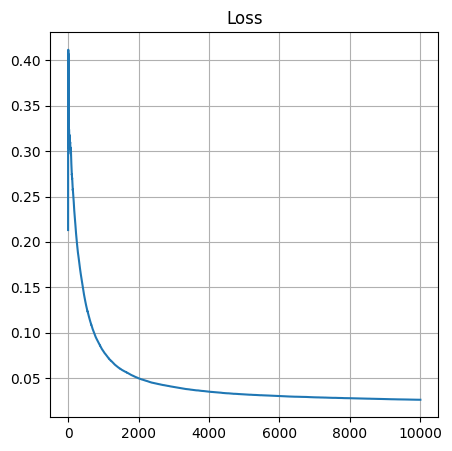

In [4]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)
optimizer = optim.Adam(bnn_multi.parameters(), lr=1e-3)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    w_conv2_dnn = dnn.conv2.weight.data.to(device)
    
    c_in_conv1, c_out_conv1, k_conv1, _ = w_conv1_dnn.size()
    c_in_conv2, c_out_conv2, k_conv2, _ = w_conv2_dnn.size()
    
    mu_bnn_conv1 = bnn_multi.conv1.mu_kernel
    mu_flat_conv1 = mu_bnn_conv1.view(-1)
    
    mu_bnn_conv2 = bnn_multi.conv2.mu_kernel
    mu_flat_conv2 = mu_bnn_conv2.view(-1)
    
    w_flat_conv1 = w_conv1_dnn.view(-1)
    w_flat_conv2 = w_conv2_dnn.view(-1)

    epslion = 1e-5
    cov_1 = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
    cov_2 = bnn_multi.conv2.get_covariance_matrix() + epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
    
    # Sampling the weight
    w_bnn_conv1 = torch.distributions.MultivariateNormal(mu_flat_conv1, cov_1).rsample().reshape(c_in_conv1, c_out_conv1, k_conv1, k_conv1)
    w_bnn_conv2 = torch.distributions.MultivariateNormal(mu_flat_conv2, cov_2).rsample().reshape(c_in_conv2, c_out_conv2, k_conv2, k_conv2)

    nll = (w_bnn_conv1 - w_conv1_dnn).pow(2).mean()
    nll += (w_bnn_conv2 - w_conv2_dnn).pow(2).mean()
    
    optimizer.zero_grad()
    nll.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu_flat_conv1.mean().item() + mu_flat_conv2.mean().item())
    
    losses.append(nll.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(5,5))
# plt.subplot(1,3,1)
# plt.imshow(cov_not_optimized[:9,:9])
# plt.title('Covariance matrix (not optimized)')

# plt.subplot(1,3,2)
# i=1
# plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
# plt.title('Covariance matrix (optimized)')
# plt.colorbar()
# plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


In [ ]:
import torch
import matplotlib.pyplot as plt

# Sample the weights
weight_dist_conv1 = torch.distributions.MultivariateNormal(
    bnn_multi.conv1.mu_kernel.view(-1),
    bnn_multi.conv1.get_covariance_matrix() +  epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
)

w_bnn_conv1 = weight_dist_conv1.rsample().reshape(6, 1, 3, 3).view(-1)
w_dnn_conv1 = dnn.conv1.weight.data.view(-1)

weight_dist_conv2 = torch.distributions.MultivariateNormal(
    bnn_multi.conv2.mu_kernel.view(-1),
    bnn_multi.conv2.get_covariance_matrix() +  epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
)    

w_bnn_conv2 = weight_dist_conv2.rsample().reshape(16, 6, 3, 3).view(-1)
w_dnn_conv2 = dnn.conv2.weight.data.view(-1)

# Visualize the difference using vertical lines

plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv1.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv1.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,2)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot DNN weights with thicker lines
plt.vlines(x, ymin=0, ymax=w_dnn_conv2.cpu().detach().numpy(), color='r', linewidth=3, label='DNN')

# Plot BNN weights with thinner lines
plt.vlines(x, ymin=0, ymax=w_bnn_conv2.cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2,2,3)
x = range(len(w_dnn_conv1.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv1 - w_dnn_conv1).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv1)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.subplot(2,2,4)
x = range(len(w_dnn_conv2.cpu().detach().numpy()))

# Plot differences
plt.vlines(x, ymin=0, ymax=(w_bnn_conv2 - w_dnn_conv2).abs().cpu().detach().numpy(), color='b', linewidth=1, label='BNN')

plt.legend()
plt.grid()
plt.title('DNN and BNN Weight Differences (Conv2)')
plt.xlabel('Weight Index')
plt.ylabel('Diff (Abs)')
plt.ylim(0,3)

plt.show()



In [ ]:
import torch

if torch.any(torch.isnan(mu_flat_conv2)) or torch.any(torch.isinf(mu_flat_conv2)):
    raise ValueError("mu_flat tensor contains NaN or Inf values")


if torch.any(torch.isnan(cov_2)) or torch.any(torch.isinf(cov_2)):
    raise ValueError("covariance matrix contains NaN or Inf values")


In [ ]:
mu_flat_conv2.shape

In [ ]:

bnn_with_good_prior = LeNet_BNN().to(device) 

'''
bnn_with_good_prior.conv1.prior_mean = bnn.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = bnn_with_good_prior.conv1.get_covariance_matrix(bnn.conv1.L_param.detach().clone(), bnn.conv1.B_param.detach().clone())

    epslion = 1e-6
    cov_1 = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
    cov_2 = bnn_multi.conv2.get_covariance_matrix() + epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
    
'''
epslion = 1e-5

bnn_with_good_prior.conv1.prior_mean = bnn_multi.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = bnn_multi.conv1.get_covariance_matrix().detach().clone() + epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)

bnn_with_good_prior.conv2.prior_mean = bnn_multi.conv2.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv2.prior_variance = bnn_multi.conv2.get_covariance_matrix().detach().clone() + epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)

bnn_with_good_prior.conv1.mu_kernel = bnn_multi.conv1.mu_kernel
# bnn_with_good_prior.conv1.L_param = bnn_multi.conv1.L_param

bnn_with_good_prior.conv2.mu_kernel = bnn_multi.conv2.mu_kernel
# bnn_with_good_prior.conv2.L_param = bnn_multi.conv2.L_param

bnn_with_good_prior.fc1 = dnn.fc1

plt.subplot(1,3,1)
plt.imshow(bnn_with_good_prior.conv1.prior_variance.cpu().detach().numpy())
# plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(bnn_with_good_prior.conv2.prior_variance.cpu().detach().numpy())

# plt.subplot(1,3,3)
# plt.imshow(bnn_with_good_prior.fc1.prior_variance.cpu().detach().numpy())
# plt.colorbar()

In [ ]:

class args:
    pass
args = args()
args.t = 1.0
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f'runs/bnn_with_good_prior_multi_new_implementation_1e-5')
train_BNN(epoch= 100, model = bnn_with_good_prior.cuda(), train_loader= train_loader, test_loader= test_loader, optimizer= optim.Adam(bnn_with_good_prior.parameters(), lr=1e-3), writer = writer, mc_runs = 100, bs = 1024, device = 'cuda', args=args, moped=False)


### mu_kernel 복사, Prior 설정 -> 즉, Cov 학습한것을 Prior로 설정한것을 제외하고 동일함 (24.7.13)
### 결과 -> 매우 좋은 성능을 보임

### Cov = I

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)
optimizer = optim.Adam(bnn_multi.parameters(), lr=1e-3)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    w_conv2_dnn = dnn.conv2.weight.data.to(device)
    
    c_in_conv1, c_out_conv1, k_conv1, _ = w_conv1_dnn.size()
    c_in_conv2, c_out_conv2, k_conv2, _ = w_conv2_dnn.size()
    
    mu_bnn_conv1 = bnn_multi.conv1.mu_kernel
    mu_flat_conv1 = mu_bnn_conv1.view(-1)
    
    mu_bnn_conv2 = bnn_multi.conv2.mu_kernel
    mu_flat_conv2 = mu_bnn_conv2.view(-1)
    
    w_flat_conv1 = w_conv1_dnn.view(-1)
    w_flat_conv2 = w_conv2_dnn.view(-1)

    epslion = 1e-5
    cov_1 = torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
    cov_2 = torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
    
    # Sampling the weight
    w_bnn_conv1 = torch.distributions.MultivariateNormal(mu_flat_conv1, cov_1).rsample().reshape(c_in_conv1, c_out_conv1, k_conv1, k_conv1)
    w_bnn_conv2 = torch.distributions.MultivariateNormal(mu_flat_conv2, cov_2).rsample().reshape(c_in_conv2, c_out_conv2, k_conv2, k_conv2)

    nll = (w_bnn_conv1 - w_conv1_dnn).pow(2).mean()
    nll += (w_bnn_conv2 - w_conv2_dnn).pow(2).mean()
    
    optimizer.zero_grad()
    nll.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu_flat_conv1.mean().item() + mu_flat_conv2.mean().item())
    
    losses.append(nll.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(5,5))
# plt.subplot(1,3,1)
# plt.imshow(cov_not_optimized[:9,:9])
# plt.title('Covariance matrix (not optimized)')

# plt.subplot(1,3,2)
# i=1
# plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
# plt.title('Covariance matrix (optimized)')
# plt.colorbar()
# plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


In [ ]:

bnn_with_good_prior = LeNet_BNN().to(device) 

'''
bnn_with_good_prior.conv1.prior_mean = bnn.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = bnn_with_good_prior.conv1.get_covariance_matrix(bnn.conv1.L_param.detach().clone(), bnn.conv1.B_param.detach().clone())

    epslion = 1e-6
    cov_1 = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
    cov_2 = bnn_multi.conv2.get_covariance_matrix() + epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
    
'''
epslion = 1e-5

bnn_with_good_prior.conv1.prior_mean = bnn_multi.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)

bnn_with_good_prior.conv2.prior_mean = bnn_multi.conv2.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv2.prior_variance = torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)

bnn_with_good_prior.conv1.mu_kernel = bnn_multi.conv1.mu_kernel
# bnn_with_good_prior.conv1.L_param = bnn_multi.conv1.L_param

bnn_with_good_prior.conv2.mu_kernel = bnn_multi.conv2.mu_kernel
# bnn_with_good_prior.conv2.L_param = bnn_multi.conv2.L_param

bnn_with_good_prior.fc1 = dnn.fc1

plt.subplot(1,3,1)
plt.imshow(bnn_with_good_prior.conv1.prior_variance.cpu().detach().numpy())
# plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(bnn_with_good_prior.conv2.prior_variance.cpu().detach().numpy())

# plt.subplot(1,3,3)
# plt.imshow(bnn_with_good_prior.fc1.prior_variance.cpu().detach().numpy())
# plt.colorbar()

In [ ]:

class args:
    pass
args = args()
args.t = 1.0
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f'runs/bnn_with_covI_multi_new_implementation_1e-5')
train_BNN(epoch= 100, model = bnn_with_good_prior.cuda(), train_loader= train_loader, test_loader= test_loader, optimizer= optim.Adam(bnn_with_good_prior.parameters(), lr=1e-3), writer = writer, mc_runs = 100, bs = 1024, device = 'cuda', args=args, moped=False)


### Randomly Initialized Cov

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bnn_multi = LeNet_BNN().to(device)
optimizer = optim.Adam([bnn_multi.conv1.mu_kernel, bnn_multi.conv2.mu_kernel], lr=1e-3)

mu_log = []
losses = []
mean_loss = []
for idx, _ in tqdm(enumerate(range(10000))):
    w_conv1_dnn = dnn.conv1.weight.data.to(device)
    w_conv2_dnn = dnn.conv2.weight.data.to(device)
    
    c_in_conv1, c_out_conv1, k_conv1, _ = w_conv1_dnn.size()
    c_in_conv2, c_out_conv2, k_conv2, _ = w_conv2_dnn.size()
    
    mu_bnn_conv1 = bnn_multi.conv1.mu_kernel
    mu_flat_conv1 = mu_bnn_conv1.view(-1)
    
    mu_bnn_conv2 = bnn_multi.conv2.mu_kernel
    mu_flat_conv2 = mu_bnn_conv2.view(-1)
    
    w_flat_conv1 = w_conv1_dnn.view(-1)
    w_flat_conv2 = w_conv2_dnn.view(-1)

    epslion = 1e-3
    cov_1 = bnn_multi.conv1.get_covariance_matrix()
    cov_2 = bnn_multi.conv2.get_covariance_matrix()
    
    # Sampling the weight
    w_bnn_conv1 = torch.distributions.MultivariateNormal(mu_flat_conv1, cov_1).rsample().reshape(c_in_conv1, c_out_conv1, k_conv1, k_conv1)
    w_bnn_conv2 = torch.distributions.MultivariateNormal(mu_flat_conv2, cov_2).rsample().reshape(c_in_conv2, c_out_conv2, k_conv2, k_conv2)

    nll = (w_bnn_conv1 - w_conv1_dnn).pow(2).mean()
    nll += (w_bnn_conv2 - w_conv2_dnn).pow(2).mean()
    
    optimizer.zero_grad()
    nll.backward()  # Do not use retain_graph=True
    optimizer.step()

    mu_log.append(mu_bnn_conv1.mean().item() + mu_bnn_conv2.mean().item())
    
    losses.append(nll.item())
    
    mean_loss.append(np.mean(losses))

plt.figure(figsize=(5,5))
# plt.subplot(1,3,1)
# plt.imshow(cov_not_optimized[:9,:9])
# plt.title('Covariance matrix (not optimized)')

# plt.subplot(1,3,2)
# i=1
# plt.imshow(bnn_multi.conv1.get_covariance_matrix().cpu().detach().numpy()[:,:][:9*i,:9*i])
# plt.title('Covariance matrix (optimized)')
# plt.colorbar()
# plt.subplot(1,3,3)
plt.plot(mean_loss[:])
plt.grid()
plt.title('Loss')


In [ ]:

bnn_with_good_prior = LeNet_BNN().to(device) 

'''
bnn_with_good_prior.conv1.prior_mean = bnn.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = bnn_with_good_prior.conv1.get_covariance_matrix(bnn.conv1.L_param.detach().clone(), bnn.conv1.B_param.detach().clone())

    epslion = 1e-6
    cov_1 = bnn_multi.conv1.get_covariance_matrix() + epslion * torch.eye(c_in_conv1 * c_out_conv1 * k_conv1 * k_conv1).to(device)
    cov_2 = bnn_multi.conv2.get_covariance_matrix() + epslion * torch.eye(c_in_conv2 * c_out_conv2 * k_conv2 * k_conv2).to(device)
    
'''
epslion = 1e-3

bnn_with_good_prior.conv1.prior_mean = bnn_multi.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = bnn_multi.conv1.get_covariance_matrix().detach().clone()

bnn_with_good_prior.conv2.prior_mean = bnn_multi.conv2.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv2.prior_variance = bnn_multi.conv2.get_covariance_matrix().detach().clone()

bnn_with_good_prior.conv1.mu_kernel = bnn_multi.conv1.mu_kernel
# bnn_with_good_prior.conv1.L_param = bnn_multi.conv1.L_param

bnn_with_good_prior.conv2.mu_kernel = bnn_multi.conv2.mu_kernel
# bnn_with_good_prior.conv2.L_param = bnn_multi.conv2.L_param

bnn_with_good_prior.fc1 = dnn.fc1

plt.subplot(1,3,1)
plt.imshow(bnn_with_good_prior.conv1.prior_variance.cpu().detach().numpy())
# plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(bnn_with_good_prior.conv2.prior_variance.cpu().detach().numpy())

# plt.subplot(1,3,3)
# plt.imshow(bnn_with_good_prior.fc1.prior_variance.cpu().detach().numpy())
# plt.colorbar()

In [ ]:

class args:
    pass
args = args()
args.t = 1.0
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f'runs/bnn_with_cov_random_multi_new_implementation')
train_BNN(epoch= 100, model = bnn_with_good_prior.cuda(), train_loader= train_loader, test_loader= test_loader, optimizer= optim.Adam(bnn_with_good_prior.parameters(), lr=1e-3), writer = writer, mc_runs = 100, bs = 1024, device = 'cuda', args=args, moped=False)


In [ ]:
# Sample the weights

# loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam([bnn_multi.conv1.mu_kernel, bnn_multi.conv1.L_param, bnn_multi.conv1.B_param], lr=1e-3)

# Log for plotting
mu_log = []
sigma_log = []
losses = []
for epoch in range(1000):
    
    mu = bnn_multi.conv1.mu_kernel
    sigma = bnn_multi.conv1.get_covariance_matrix(bnn_multi.conv1.L_param, bnn_multi.conv1.B_param)

    k = 
    loss_val = 0.5 * (k * torch.log(2 * torch.pi) + torch.log(cov_det) + mahalanobis_dist)
    # loss_val = 0.5 * torch.mean((mu - w_conv1_dnn)**2 / sigma + sigma )
        
        
    
    # loss_val = loss(w, w_conv1_dnn)
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    mu_log.append(mu.mean().item())
    sigma_log.append(sigma.mean().item())
    losses.append(loss_val.item())
    
# plot training progress
plt.plot(losses)
plt.plot(mu_log)
plt.plot(sigma_log)
plt.grid()
plt.legend(['loss', 'mu', 'sigma'])

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 예시 데이터, 실제 데이터로 대체하세요.
mu_kernel = bnn_uni.conv1.mu_kernel  # 실제 mu_kernel 값으로 대체
rho_kernel = bnn_uni.conv1.rho_kernel  # 실제 rho_kernel 값으로 대체
w_dnn = dnn.conv1.weight.data
# sigma_weight 계산
sigma_weight = torch.log1p(torch.exp(rho_kernel))

plt.figure(figsize=(15,15))
for idx, (w_target, mu, sigma) in enumerate(zip(w_dnn, mu_kernel, sigma_weight)):
    
    print(w_target.shape, mu.shape, sigma.shape)
    w_target = w_target.cpu().detach().numpy()
    plt.subplot(6,1, idx+1)
    for i in range(3):
        
        for j in range(3):
            
            plt.axvline(x=w_target[0,i,j], color='r', linestyle='--', label='target')
            
            x = np.linspace(mu[0,i,j].item() - 3 * sigma[0,i,j].item(), mu[0,i,j].item() + 3 * sigma[0,i,j].item(), 1000)
            pdf = norm.pdf(x, loc=mu[0,i,j].item(), scale= sigma[0,i,j].item())
            # plt.subplot(3,3,i+j+1)

            plt.plot(x, pdf, label=f'N({mu[0,i,j].item():.2f}, {sigma[0,i,j].item():.2f})')
            

In [ ]:
from bayesian_torch.layers.variational_layers.conv_variational_layers import Conv2dReparameterization_Multivariate

# Hook 함수 정의
def hook_fn(module, input, output):
    if isinstance(module, Conv2dReparameterization_Multivariate):
        if module == bnn.conv1:
            bnn_conv1_out.append(output)
        elif module == bnn.conv2:
            bnn_conv2_out.append(output)
    # elif isinstance(module, nn.AvgPool2d):
    #     bnn_pool_out.append(output)


# 모델 초기화
# dnn = LeNet()
bnn = LeNet_BNN()  # 실제로는 Bayesian Neural Network여야 함

# Hook을 저장할 리스트
dnn_conv1_out = []
dnn_conv2_out = []
dnn_pool_out = []
bnn_conv1_out = []
bnn_conv2_out = []
bnn_pool_out = []

# Hook 등록
dnn.conv1.register_forward_hook(lambda m, i, o: dnn_conv1_out.append(o))
dnn.conv2.register_forward_hook(lambda m, i, o: dnn_conv2_out.append(o))
dnn.pool.register_forward_hook(lambda m, i, o: dnn_pool_out.append(o))

bnn.conv1.register_forward_hook(hook_fn)
bnn.conv2.register_forward_hook(hook_fn)
bnn.pool.register_forward_hook(hook_fn)

# 옵티마이저 설정
optimizer = torch.optim.Adam(bnn.parameters(), lr=1e-3)#, momentum=0.9, nesterov=True)

# Knowledge Distillation 학습 루프
epochs = 10
for e in range(epochs):
    pbar = tqdm(enumerate(train_loader))
    dnn.eval().cuda()
    bnn.train().cuda()
    
    losses = []
    for batch_idx, (data, target) in pbar:
        data, target = data.cuda(), target.cuda()
        
        with torch.no_grad():
            dnn_conv1_out.clear()
            dnn_conv2_out.clear()
            dnn_pool_out.clear()
            
            y_t = dnn(data)
            # output_t = [dnn_conv1_out[0], dnn_conv2_out[0], y_t]
            output_t = [dnn_conv1_out[0]]
            
        bnn_conv1_out.clear()
        bnn_conv2_out.clear()
        bnn_pool_out.clear()
        
        y_s, _ = bnn(data)
        # output_s = [bnn_conv1_out[0][0], bnn_conv2_out[0][0], y_s]
        output_s = [bnn_conv1_out[0][0]]
        
        loss = 0
        for idx, (t, s) in enumerate(zip(output_t, output_s)):
            loss += F.mse_loss(s, t)
        
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pbar.set_description(f"Loss: {np.mean(losses):.3f} Epoch: {e}")


In [ ]:
# Visualize the covariance matrix

import matplotlib.pyplot as plt
conv1_cov = bnn.conv1.get_covariance_matrix(bnn.conv1.L_param, bnn.conv1.B_param).cpu().detach().numpy()
# conv2_cov = bnn.conv2.get_covariance_matrix(bnn.conv2.L_param, bnn.conv2.B_param).cpu().detach().numpy()

In [ ]:
i=1
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(conv1_cov[:9*i,:9*i], cmap='plasma')

i=9
plt.subplot(1,2,2)
plt.imshow(conv1_cov[:9*i,:9*i], cmap='plasma')

In [ ]:

bnn_with_good_prior = LeNet_BNN()
bnn_with_good_prior.conv1.prior_mean = bnn.conv1.mu_kernel.detach().clone().flatten()
bnn_with_good_prior.conv1.prior_variance = bnn_with_good_prior.conv1.get_covariance_matrix(bnn.conv1.L_param.detach().clone(), bnn.conv1.B_param.detach().clone())

# bnn_with_good_prior.conv2.prior_mean = bnn.conv2.mu_kernel.detach().clone().flatten()
# bnn_with_good_prior.conv2.prior_variance = bnn_with_good_prior.conv2.get_covariance_matrix(bnn.conv2.L_param.detach().clone(), bnn.conv2.B_param.detach().clone())

train_BNN(10, bnn_with_good_prior)


In [ ]:
# Visualize the covariance matrix
import matplotlib.pyplot as plt
conv1_cov = naiive_bnn.conv1.get_covariance_matrix(naiive_bnn.conv1.L_param, naiive_bnn.conv1.B_param).cpu().detach().numpy()

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(conv1_cov[:,:], cmap='plasma')

conv1_cov2 = bnn_with_good_prior.conv1.get_covariance_matrix(bnn_with_good_prior.conv1.L_param, bnn_with_good_prior.conv1.B_param).cpu().detach().numpy()
plt.subplot(1,2,2)
plt.imshow(conv1_cov2[:,:], cmap='plasma')